# Cell type neighborhood gallery

In this notebook, we will visualize a set of cell type neighborhoods to produce visualizations similar to Figure 2 of [Yao et al](https://doi.org/10.1101/2023.03.06.531121).


In [1]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pathlib

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20231215'
download_base = pathlib.Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.load_manifest(f'releases/{version}/manifest.json')
abc_cache.current_manifest

'releases/20231215/manifest.json'

Read in the list of neighborhood spatial embedding maps

In [4]:
maps = abc_cache.get_metadata_dataframe(directory='WMB-neighborhoods', file_name='dimension_reduction')
maps.set_index('name', inplace=True)
print("number of maps:", len(maps))
maps

number of maps: 8


label  \
name                                                      
HY-EA-Glut-GABA            UMAP20230830-HY-EA-Glut-GABA   
MB-HB-CB-GABA                UMAP20230830-MB-HB-CB-GABA   
MB-HB-Glut-Sero-Dopa  UMAP20230830-MB-HB-Glut-Sero-Dopa   
NN-IMN-GC                        UMAP20230830-NN-IMN-GC   
Pallium-Glut                  UMAP20230830-Pallium-Glut   
Subpallium-GABA            UMAP20230830-Subpallium-GABA   
TH-EPI-Glut                    UMAP20230830-TH-EPI-Glut   
WholeBrain                      UMAP20230830-WholeBrain   

                                                            description  \
name                                                                      
HY-EA-Glut-GABA       Glutamatergic and GABAergic neurons in hypotha...   
MB-HB-CB-GABA         GABAergic neurons in midbrain, hindbrain, and ...   
MB-HB-Glut-Sero-Dopa  Glutamatergic, serotonergic and dopaminergic n...   
NN-IMN-GC             Non-neuronal cells, immature neurons, granule ...   
Pallium-Glut          Glutamatergic neurons from cerebral cortex (de...   
Subpallium-GABA       Telencephalic GABAergic neurons from cerebral ...   
TH-EPI-Glut           Glutamatergic neurons from thalamus and epitha...   
WholeBrain            All cells in the whole mouse brain (5322 clust...   

                      number_of_cells               cluster_group_label  
name                                                                     
HY-EA-Glut-GABA                295448       CCN20230722_HY-EA-Glut-GABA  
MB-HB-CB-GABA                  186775         CCN20230722_MB-HB-CB-GABA  
MB-HB-Glut-Sero-Dopa           180669  CCN20230722_MB-HB-Glut-Sero-Dopa  
NN-IMN-GC                     1418529             CCN20230722_NN-IMN-GC  
Pallium-Glut                  1494801          CCN20230722_Pallium-Glut  
Subpallium-GABA                611423       CCN20230722_Subpallium-GABA  
TH-EPI-Glut                    126171           CCN20230722_TH-EPI-Glut  
WholeBrain                    4042976            CCN20230722_WholeBrain

Read in the extended 10x and MERFISH cell metadata created in the cluster neighborhood tutorial

In [5]:
cell_10x = abc_cache.get_metadata_dataframe(
    directory='WMB-neighborhoods',
    file_name='10x_cell_metadata_with_group_membership',
    dtype={"neurotransmitter": str}
)
cell_10x.set_index('cell_label', inplace=True)
print("number of 10x cells:", len(cell_10x))

10x_cell_metadata_with_group_membership.csv: 100%|██████████████████████████████████████████████████████████████| 1.57G/1.57G [00:44<00:00, 35.5MMB/s]


number of 10x cells: 4042976


In [7]:
cell_merfish = abc_cache.get_metadata_dataframe(
    directory='WMB-neighborhoods',
    file_name='merfish_cell_metadata_with_group_membership',
    dtype={"cell_label": str, "neurotransmitter": str}
)
cell_merfish.set_index('cell_label', inplace=True)
print("number of merfish cells:", len(cell_merfish))

merfish_cell_metadata_with_group_membership.csv: 100%|██████████████████████████████████████████████████████████| 1.20G/1.20G [00:34<00:00, 34.8MMB/s]


number of merfish cells: 3938808


Create a set of helper functions to read in the neighborhood specific UMAP coordinates and to plot cells in a UMAP or anatomical context and apply them a set of neighborhood

In [8]:
def fetch_coord( group ) :
    mlabel = maps.loc[group, 'label']
    coord = abc_cache.get_metadata_dataframe(
        directory='WMB-neighborhoods',
        file_name=mlabel
    )
    coord.set_index('cell_label', inplace=True)
    return coord

In [9]:
def plot_umap(xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    ax.set_xlim(-18, 27)
    ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

In [10]:
def plot_sections(df, group, feature, blist, fig_width = 20, fig_height = 5):
    
    fig, ax = plt.subplots(1, len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist):
        
        filtered = df[df['brain_section_label'] == bsl].copy()
        filtered.sort_values(group, ascending=True, inplace=True)
        
        xx = filtered['x']
        yy = filtered['y']

        vv = filtered[feature].copy()
        pred = (filtered[group] == False)
        vv[pred] = '#f5f5f5'
        
        ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0, 11)
        ax[idx].set_ylim(11, 0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s: %s" % (group, bsl))
        
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()
    return fig, ax

### Neighborhood: Pallium-Glut

UMAP20230830-Pallium-Glut.csv: 100%|████████████████████████████████████████████████████████████████████████████| 84.5M/84.5M [00:02<00:00, 41.4MMB/s]


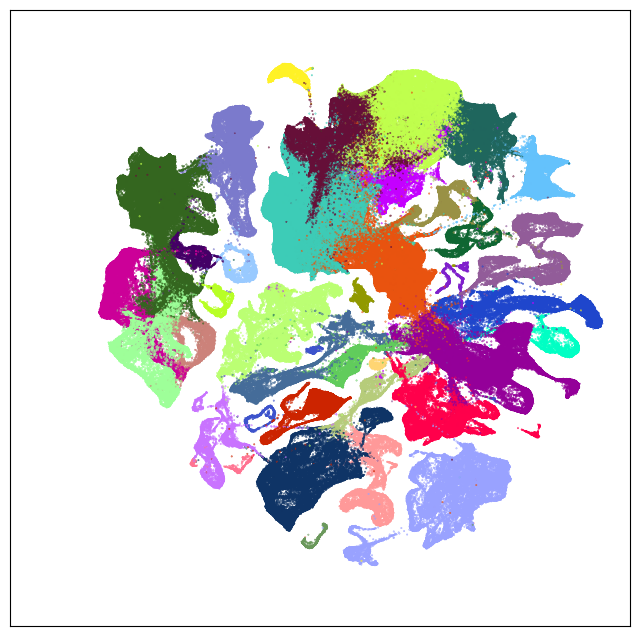

In [11]:
group = 'Pallium-Glut'
coord = fetch_coord(group)
fig, ax = plot_umap(coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

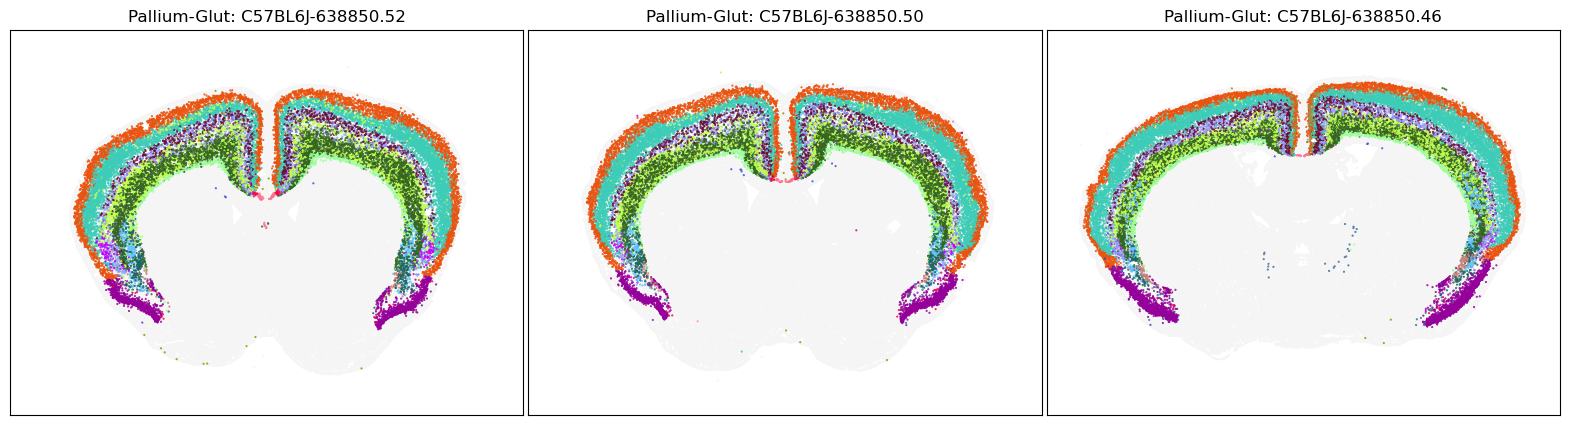

In [12]:
blist = ['C57BL6J-638850.52', 'C57BL6J-638850.50', 'C57BL6J-638850.46']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

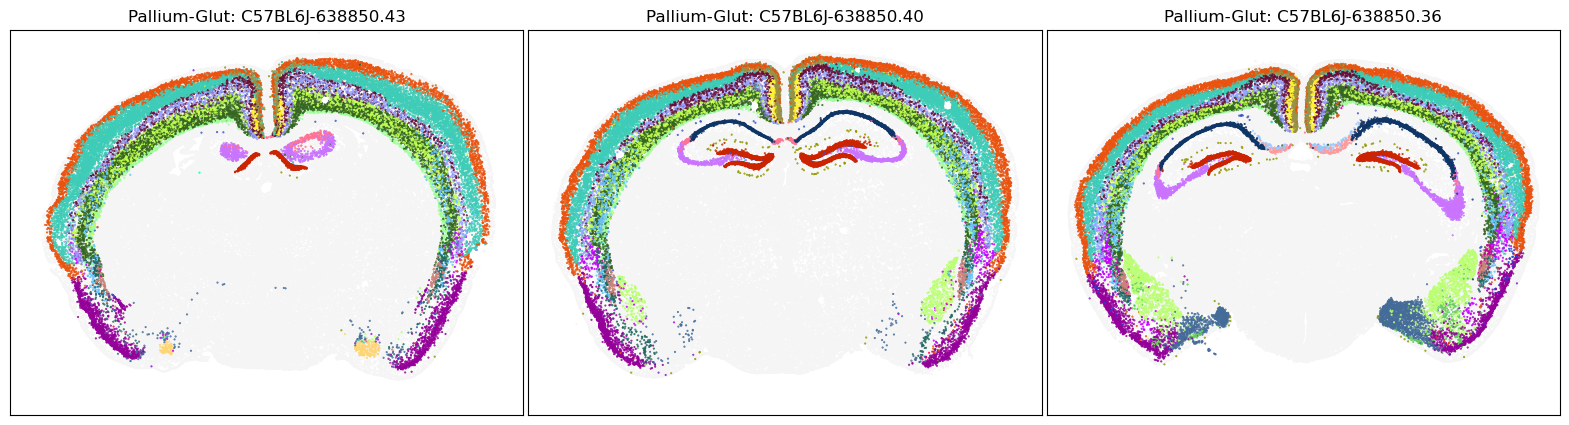

In [13]:
blist = ['C57BL6J-638850.43', 'C57BL6J-638850.40', 'C57BL6J-638850.36']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

### Neighborhood: Subpallium-GABA

UMAP20230830-Subpallium-GABA.csv: 100%|█████████████████████████████████████████████████████████████████████████| 27.7M/27.7M [00:01<00:00, 27.0MMB/s]


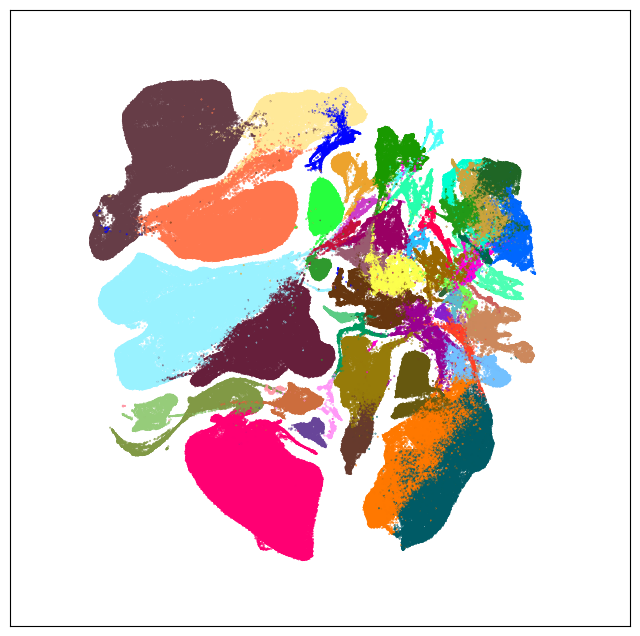

In [14]:
group = 'Subpallium-GABA'
coord = fetch_coord(group)
fig, ax = plot_umap( oord['x'], coord['y'], cc=cell_10x.loc[coord.index, 'subclass_color'])

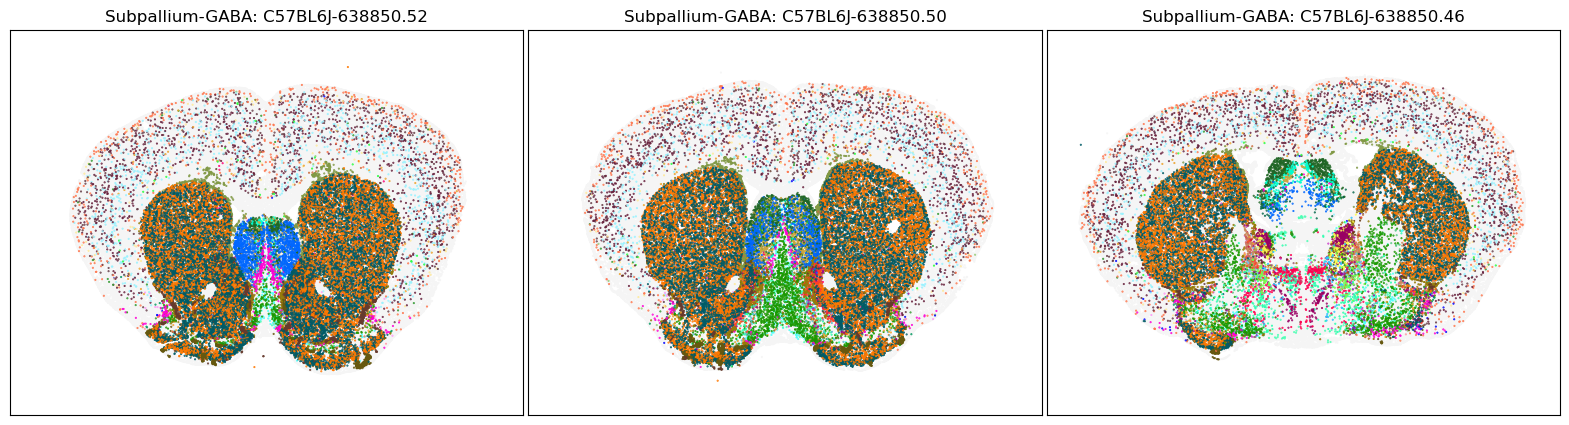

In [15]:
blist = ['C57BL6J-638850.52', 'C57BL6J-638850.50', 'C57BL6J-638850.46']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

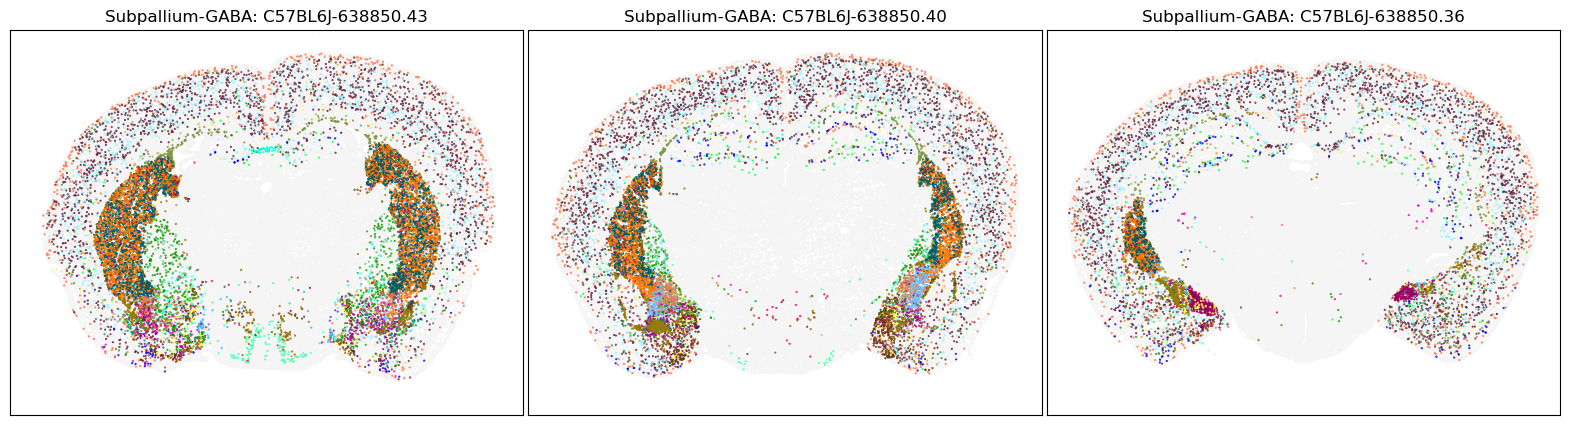

In [16]:
blist = ['C57BL6J-638850.43', 'C57BL6J-638850.40', 'C57BL6J-638850.36']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

### Neighborhood: HY-EA-Glut-GABA

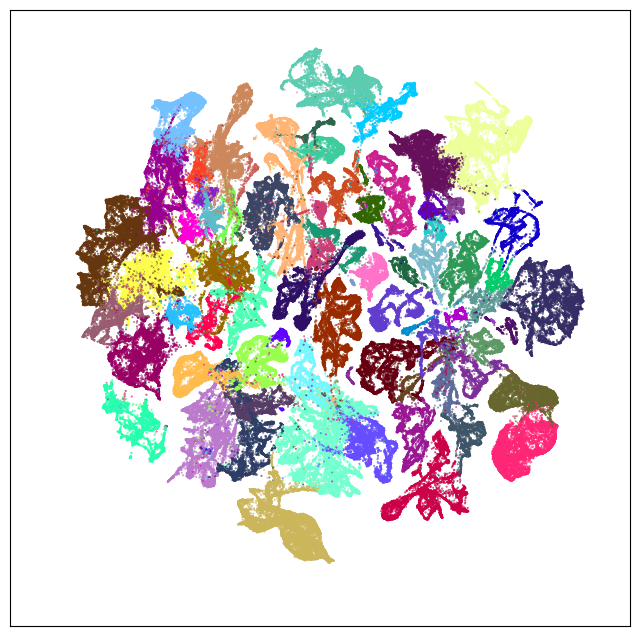

In [17]:
group = 'HY-EA-Glut-GABA'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index, 'subclass_color'])

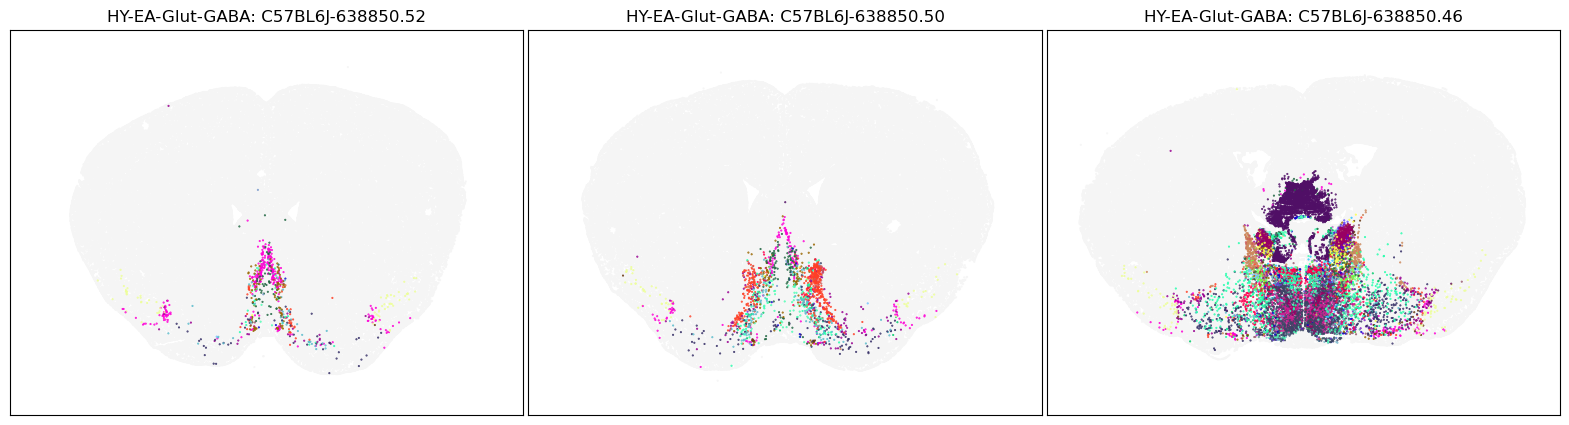

In [18]:
blist = ['C57BL6J-638850.52', 'C57BL6J-638850.50', 'C57BL6J-638850.46']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

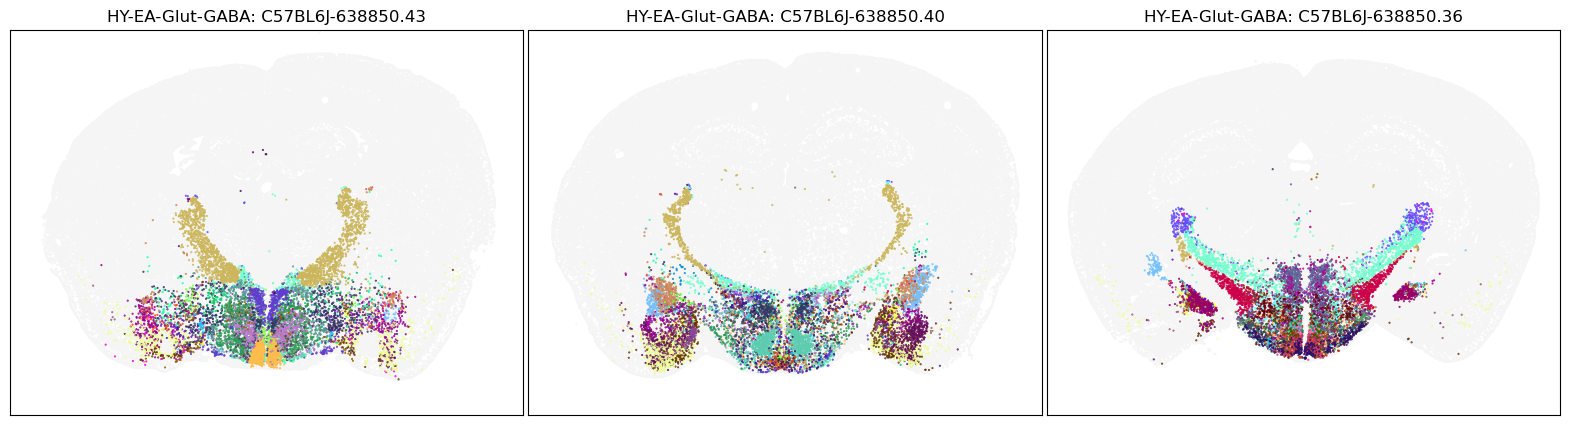

In [19]:
blist = ['C57BL6J-638850.43', 'C57BL6J-638850.40', 'C57BL6J-638850.36']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

### Neighborhood: TH-EPI-Glut

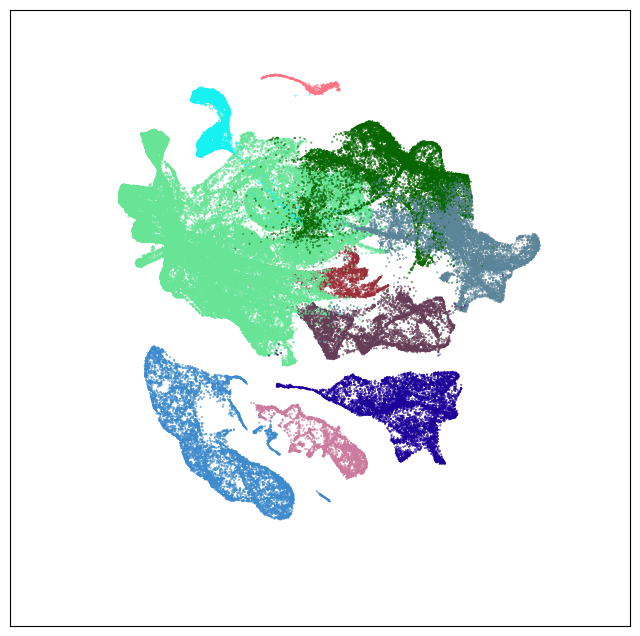

In [20]:
group = 'TH-EPI-Glut'
coord = fetch_coord(group)
fig, ax = plot_umap(coord['x'], coord['y'], cc=cell_10x.loc[coord.index, 'subclass_color'])

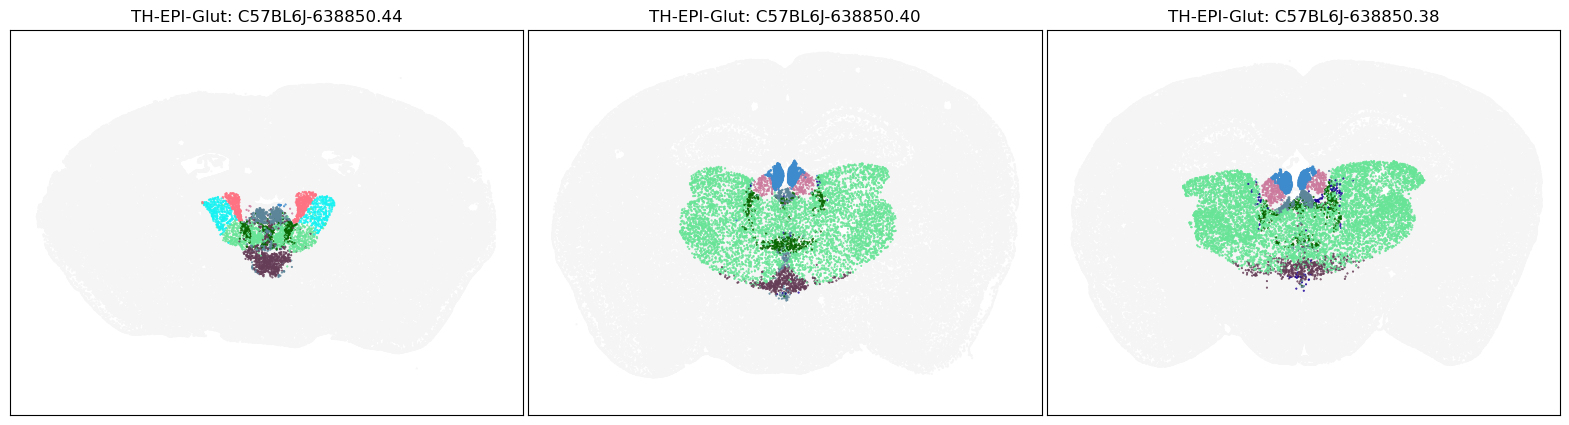

In [21]:
blist = ['C57BL6J-638850.44', 'C57BL6J-638850.40', 'C57BL6J-638850.38']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

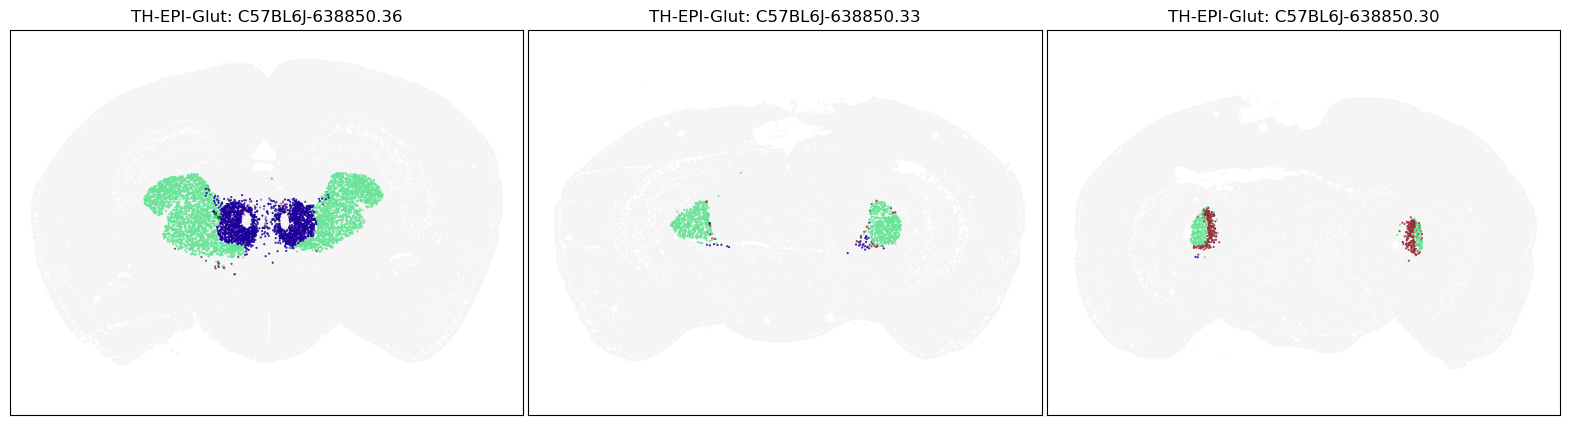

In [22]:
blist = ['C57BL6J-638850.36', 'C57BL6J-638850.33', 'C57BL6J-638850.30']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

### Neighborhood: MB-HB-CB-GABA	

UMAP20230830-MB-HB-CB-GABA.csv: 100%|███████████████████████████████████████████████████████████████████████████| 9.32M/9.32M [00:00<00:00, 20.5MMB/s]


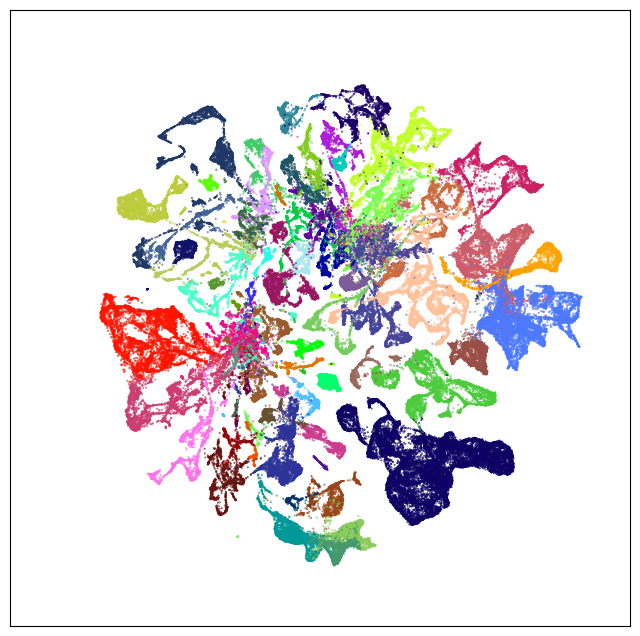

In [23]:
group = 'MB-HB-CB-GABA'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index, 'subclass_color'])

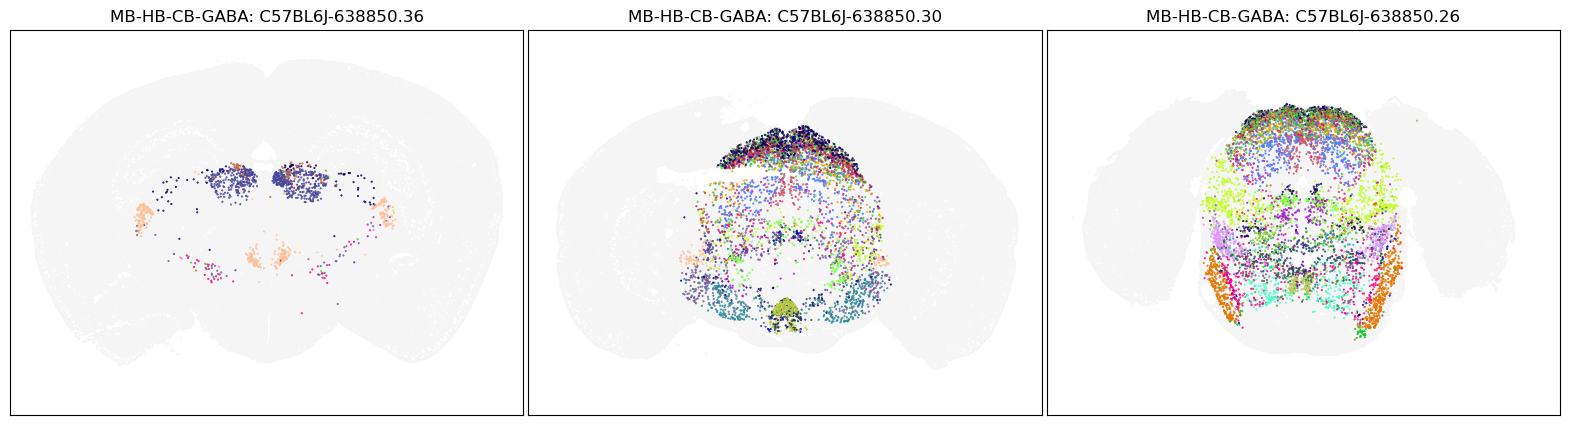

In [24]:
blist = ['C57BL6J-638850.36', 'C57BL6J-638850.30', 'C57BL6J-638850.26']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

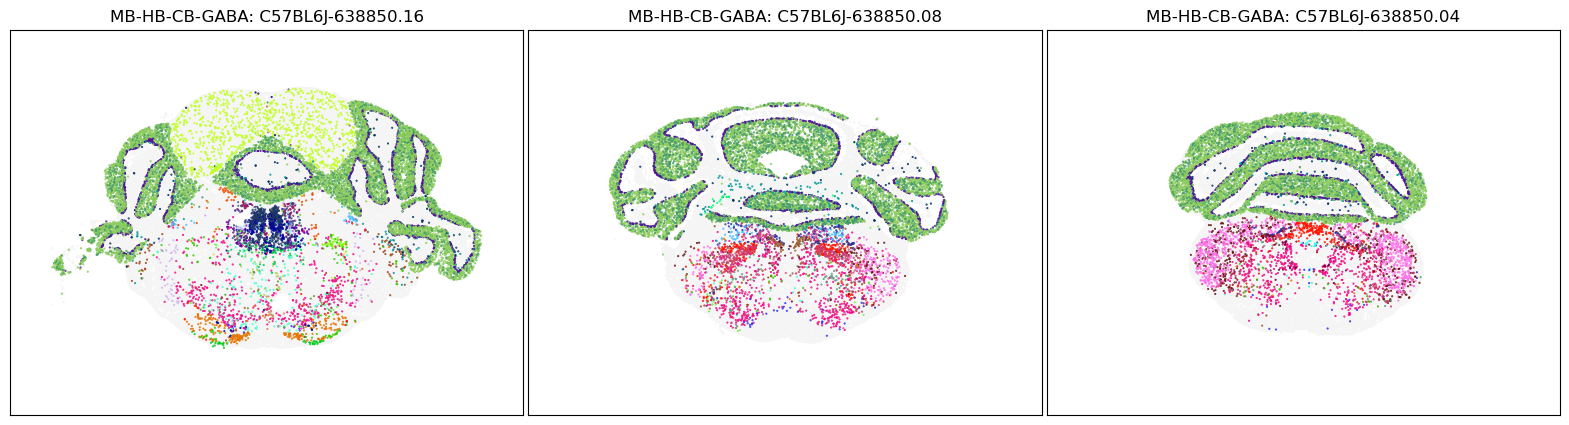

In [25]:
blist = ['C57BL6J-638850.16', 'C57BL6J-638850.08', 'C57BL6J-638850.04']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

### Neighborhood: MB-HB-Glut-Sero-Dopa

UMAP20230830-MB-HB-Glut-Sero-Dopa.csv: 100%|████████████████████████████████████████████████████████████████████| 8.42M/8.42M [00:00<00:00, 12.2MMB/s]


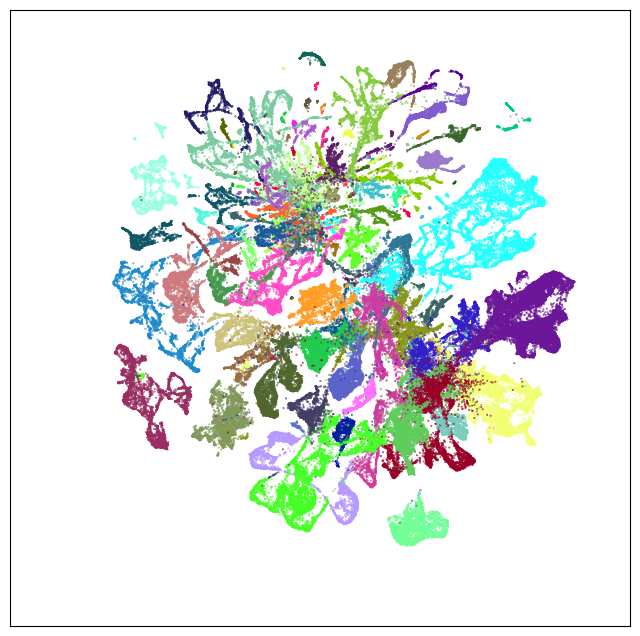

In [26]:
group = 'MB-HB-Glut-Sero-Dopa'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index, 'subclass_color'])

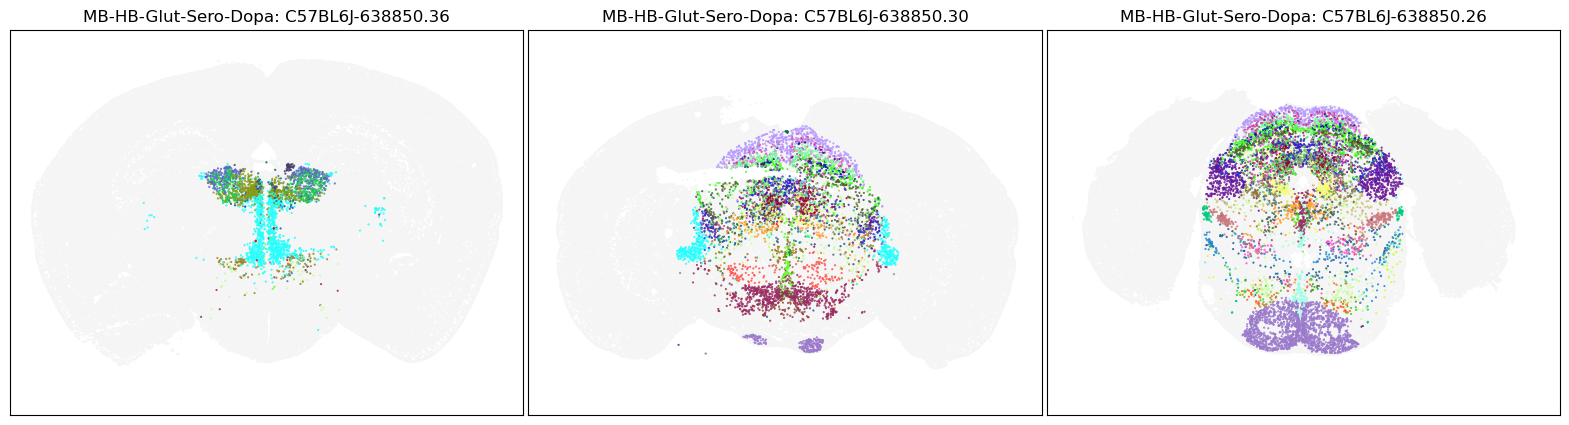

In [27]:
blist = ['C57BL6J-638850.36', 'C57BL6J-638850.30', 'C57BL6J-638850.26']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

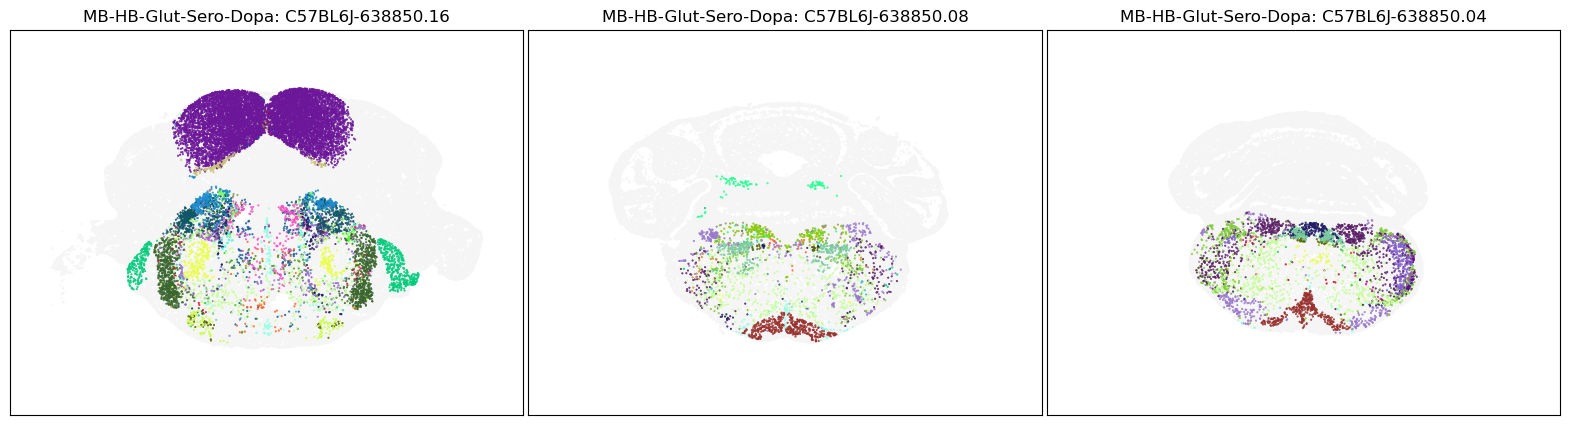

In [28]:
blist = ['C57BL6J-638850.16', 'C57BL6J-638850.08', 'C57BL6J-638850.04']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

### Neighborhood: NN-IMN-GC

UMAP20230830-NN-IMN-GC.csv: 100%|███████████████████████████████████████████████████████████████████████████████| 83.4M/83.4M [00:02<00:00, 32.2MMB/s]


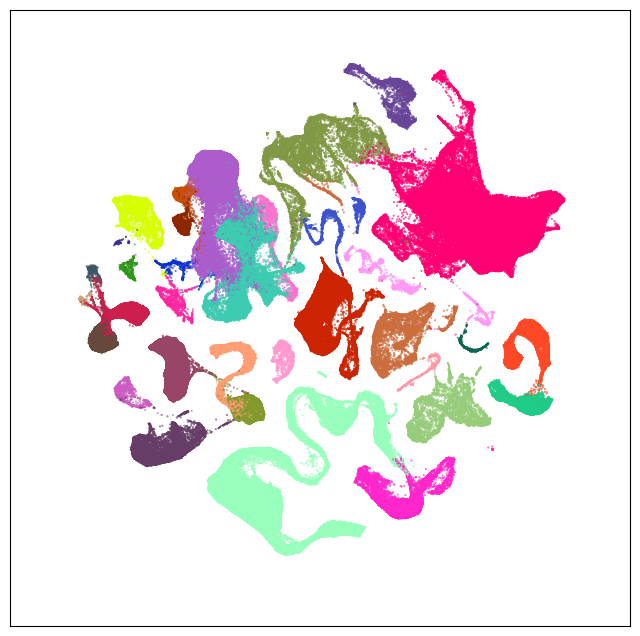

In [29]:
group = 'NN-IMN-GC'
coord = fetch_coord(group)
fig, ax = plot_umap(coord['x'], coord['y'], cc=cell_10x.loc[coord.index, 'subclass_color'])

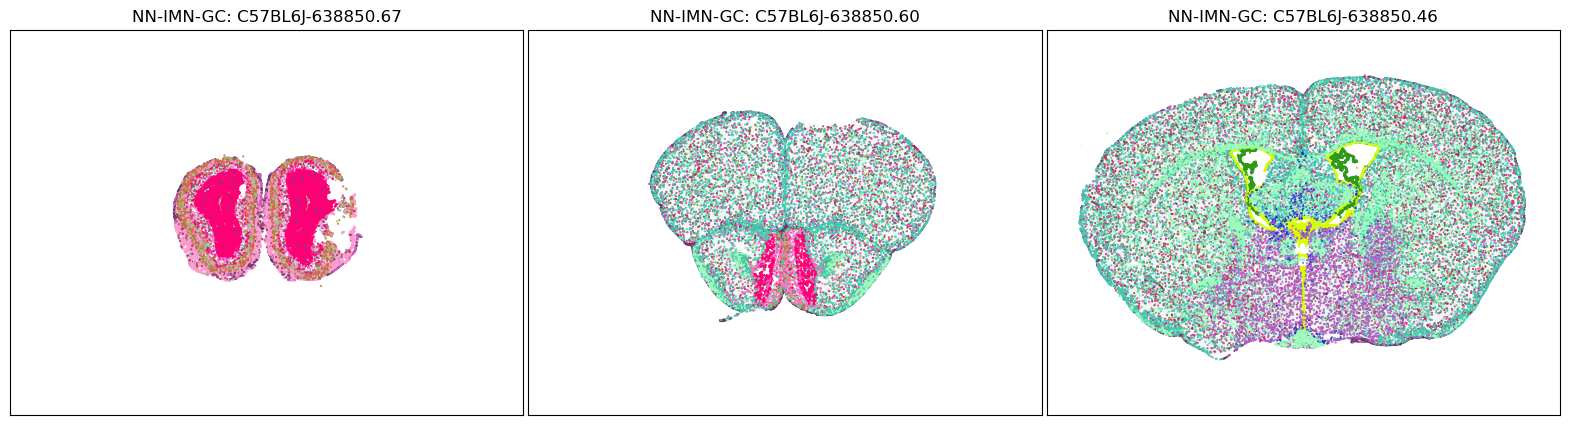

In [30]:
blist = ['C57BL6J-638850.67','C57BL6J-638850.60','C57BL6J-638850.46']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)

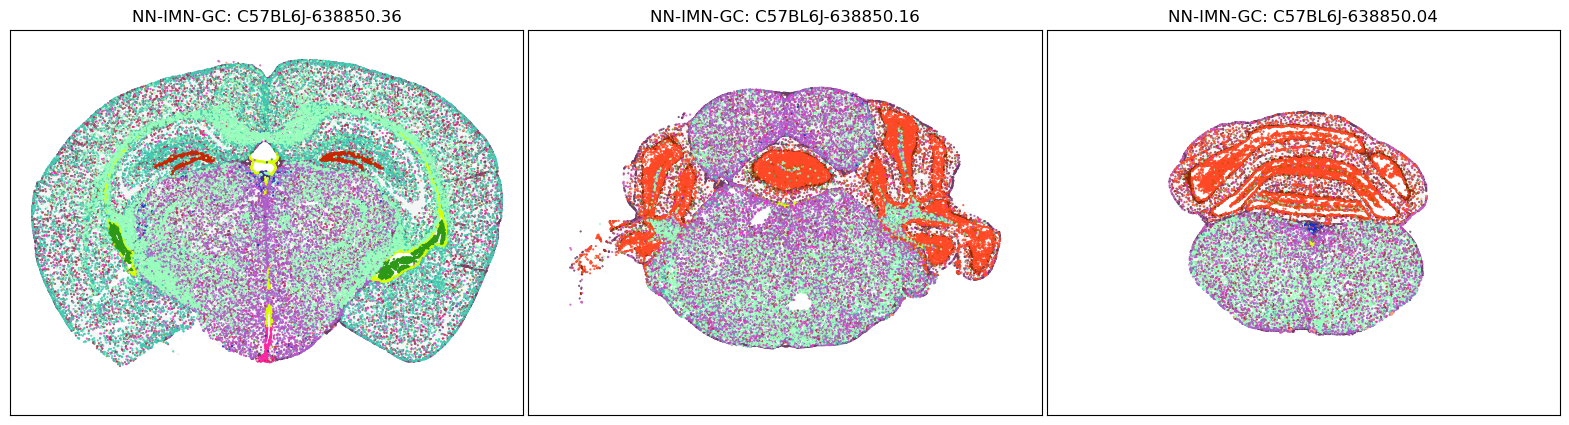

In [31]:
blist = ['C57BL6J-638850.36', 'C57BL6J-638850.16', 'C57BL6J-638850.04']
fig, ax = plot_sections(cell_merfish, group, 'subclass_color', blist)